In [11]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.utils import class_weight
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, Dropout, BatchNormalization
from tensorflow.keras.models import model_from_json, load_model
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
print(tf.__version__)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    if filenames:
        csv_path = os.path.join(dirname, filenames[0])
print(csv_path)

2.3.1
/kaggle/input/fetal-health-classification/fetal_health.csv


In [61]:
from tensorflow.keras import backend as K

def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_score(y_true, y_pred):
    prec = precision(y_true, y_pred)
    rec = recall(y_true, y_pred)
    return 2*((prec*rec)/(prec+rec+K.epsilon()))

In [3]:
df = pd.read_csv(csv_path)
df.head()

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,...,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency,fetal_health
0,120.0,0.000,0.0,0.000,0.000,0.0,0.0,73.0,0.5,43.0,...,62.0,126.0,2.0,0.0,120.0,137.0,121.0,73.0,1.0,2.0
1,132.0,0.006,0.0,0.006,0.003,0.0,0.0,17.0,2.1,0.0,...,68.0,198.0,6.0,1.0,141.0,136.0,140.0,12.0,0.0,1.0
2,133.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.1,0.0,...,68.0,198.0,5.0,1.0,141.0,135.0,138.0,13.0,0.0,1.0
3,134.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,11.0,0.0,137.0,134.0,137.0,13.0,1.0,1.0
4,132.0,0.007,0.0,0.008,0.000,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,9.0,0.0,137.0,136.0,138.0,11.0,1.0,1.0


In [31]:
df_cols = df.columns.values
Y = df[df_cols[-1]].values
X = df[df_cols[:-1]].values

Y = Y - 1
Y = Y.astype(int)

X, Y = shuffle(X, Y)
Ntrain = int(len(Y) * 0.7)

Xtrain, Xtest = X[:Ntrain], X[Ntrain:]
Ytrain, Ytest = Y[:Ntrain], Y[Ntrain:]
print(Ytrain.shape)
print(Xtrain.shape)

(1488,)
(1488, 21)


Handling Classes

In [32]:
from collections import Counter
classes = list(set(Ytrain))
class_data = dict(Counter(Ytrain))
class_data

{0: 1162, 1: 201, 2: 125}

Set class weights :

w(j) = n / (k * n(j))

In [51]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(Ytrain),
                                                 Ytrain)
class_weights = {i : class_weights[i] for i in range(len(set(Ytrain)))}
class_weights

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2], y=[0 0 1 ... 0 0 0] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


{0: 0.4268502581755594, 1: 2.4676616915422884, 2: 3.968}

In [52]:
Xscalar = StandardScaler()
Xscalar.fit(Xtrain)

Xtrain = Xscalar.transform(Xtrain)
Xtest = Xscalar.transform(Xtest)

In [70]:
num_epoches = 80
batch_size = 32
val_split = 0.1

Model 1: Training The DNN Model

In [73]:
def classifier1():
    n_features = Xtrain.shape[1]
    inputs = Input(shape=(n_features,))
    x = Dense(512, activation='relu')(inputs)
    x = Dense(256, activation='relu')(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dense(64, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(3, activation='softmax')(x)
    model = Model(inputs, outputs)
    
    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer='adam',
        metrics=['acc',f1_score,precision, recall] 
    )
    history = model.fit(
                    Xtrain,
                    Ytrain,
                    batch_size=batch_size,
                    epochs=num_epoches,
                    validation_split=val_split,
                    class_weight=class_weights
                    )
    return history, model
    
def plot_metrics(history):
    loss_train = history.history['loss']
    loss_val = history.history['val_loss']
    
    loss_train = np.cumsum(loss_train) / np.arange(1,num_epoches+1)
    loss_val = np.cumsum(loss_val) / np.arange(1,num_epoches+1)
    plt.plot(loss_train, 'r', label='Training loss')
    plt.plot(loss_val, 'b', label='validation loss')
    plt.title('Training and Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    acc_train = history.history['acc']
    acc_val = history.history['val_acc']
    
    plt.plot(acc_train, 'r', label='Training loss')
    plt.plot(acc_val, 'b', label='validation loss')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    precision_train = history.history['precision']
    precision_val = history.history['val_precision']
    
    plt.plot(precision_train, 'r', label='Training loss')
    plt.plot(precision_val, 'b', label='validation loss')
    plt.title('Training and Validation Precision')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    recall_train = history.history['recall']
    recall_val = history.history['val_recall']
    
    plt.plot(recall_train, 'r', label='Training loss')
    plt.plot(recall_val, 'b', label='validation loss')
    plt.title('Training and Validation Recall')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    f1_score_train = history.history['f1_score']
    f1_score_val = history.history['val_f1_score']
    
    plt.plot(f1_score_train, 'r', label='Training loss')
    plt.plot(f1_score_val, 'b', label='validation loss')
    plt.title('Training and Validation F1 Score')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


Epoch 1/80
42/42 [==============================] - 0s 10ms/step - loss: 0.7002 - acc: 0.7005 - f1_score: 0.4894 - precision: 0.3674 - recall: 0.9600 - val_loss: 0.8262 - val_acc: 0.7047 - val_f1_score: 0.2889 - val_precision: 0.2167 - val_recall: 0.4333
Epoch 2/80
42/42 [==============================] - 0s 5ms/step - loss: 0.4332 - acc: 0.8417 - f1_score: 0.4040 - precision: 0.2526 - recall: 1.0578 - val_loss: 0.6479 - val_acc: 0.7785 - val_f1_score: 0.3127 - val_precision: 0.1941 - val_recall: 0.8600
Epoch 3/80
42/42 [==============================] - 0s 6ms/step - loss: 0.4167 - acc: 0.8409 - f1_score: 0.3854 - precision: 0.2408 - recall: 1.0385 - val_loss: 0.5175 - val_acc: 0.7852 - val_f1_score: 0.2504 - val_precision: 0.1527 - val_recall: 0.7267
Epoch 4/80
42/42 [==============================] - 0s 5ms/step - loss: 0.3555 - acc: 0.8581 - f1_score: 0.3911 - precision: 0.2455 - recall: 1.0504 - val_loss: 0.4178 - val_acc: 0.8121 - val_f1_score: 0.2604 - val_precision: 0.1531 - va

42/42 [==============================] - 0s 5ms/step - loss: 0.1590 - acc: 0.9410 - f1_score: 0.3710 - precision: 0.2308 - recall: 1.0125 - val_loss: 0.2725 - val_acc: 0.9128 - val_f1_score: 0.2806 - val_precision: 0.1628 - val_recall: 1.0667
Epoch 34/80
42/42 [==============================] - 0s 5ms/step - loss: 0.1178 - acc: 0.9544 - f1_score: 0.3789 - precision: 0.2359 - recall: 1.0359 - val_loss: 0.3354 - val_acc: 0.9262 - val_f1_score: 0.2701 - val_precision: 0.1565 - val_recall: 1.0333
Epoch 35/80
42/42 [==============================] - 0s 5ms/step - loss: 0.0820 - acc: 0.9597 - f1_score: 0.3704 - precision: 0.2302 - recall: 1.0138 - val_loss: 0.3347 - val_acc: 0.9195 - val_f1_score: 0.2600 - val_precision: 0.1509 - val_recall: 0.9833
Epoch 36/80
42/42 [==============================] - 0s 5ms/step - loss: 0.1009 - acc: 0.9500 - f1_score: 0.3677 - precision: 0.2288 - recall: 1.0107 - val_loss: 0.6302 - val_acc: 0.8792 - val_f1_score: 0.2596 - val_precision: 0.1503 - val_recall:

42/42 [==============================] - 0s 4ms/step - loss: 0.1005 - acc: 0.9597 - f1_score: 0.3681 - precision: 0.2299 - recall: 1.0167 - val_loss: 0.5742 - val_acc: 0.9060 - val_f1_score: 0.2596 - val_precision: 0.1503 - val_recall: 1.0000
Epoch 66/80
42/42 [==============================] - 0s 4ms/step - loss: 0.0503 - acc: 0.9724 - f1_score: 0.3619 - precision: 0.2265 - recall: 1.0022 - val_loss: 0.4978 - val_acc: 0.9128 - val_f1_score: 0.2596 - val_precision: 0.1503 - val_recall: 1.0000
Epoch 67/80
42/42 [==============================] - 0s 4ms/step - loss: 0.1124 - acc: 0.9686 - f1_score: 0.3654 - precision: 0.2272 - recall: 1.0026 - val_loss: 0.6039 - val_acc: 0.8926 - val_f1_score: 0.2701 - val_precision: 0.1565 - val_recall: 1.0333
Epoch 68/80
42/42 [==============================] - 0s 4ms/step - loss: 0.1482 - acc: 0.9410 - f1_score: 0.3701 - precision: 0.2333 - recall: 1.0253 - val_loss: 0.4658 - val_acc: 0.8926 - val_f1_score: 0.2596 - val_precision: 0.1503 - val_recall:

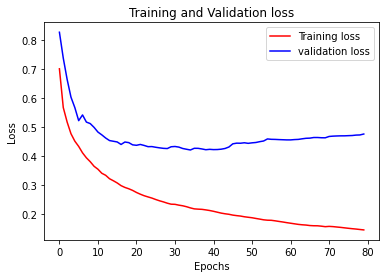

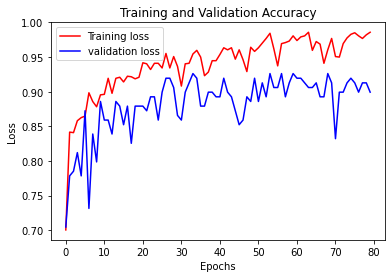

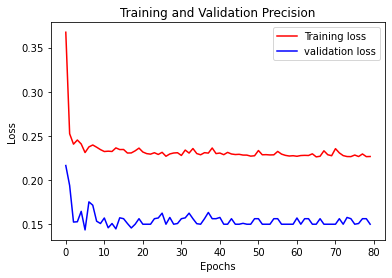

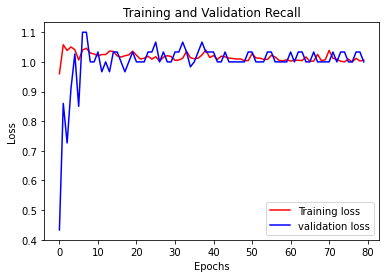

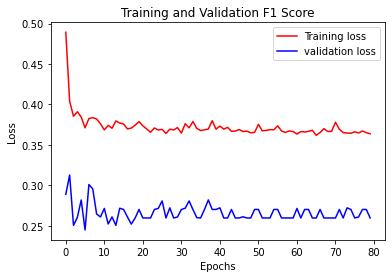

In [74]:
history1, model1 = classifier1()
plot_metrics(history1)

In [90]:
P = model1.predict(Xtest)
Ypred = P.argmax(axis=1)
model1.evaluate(Xtest, Ytest)

20/20 [==============================] - 0s 1ms/step - loss: 0.4703 - acc: 0.9216 - f1_score: 0.3717 - precision: 0.2306 - recall: 1.0109


[0.4702875018119812,
 0.9216300845146179,
 0.3717126250267029,
 0.23061490058898926,
 1.0109126567840576]